Seeking an analytic solution to the expected edit distance between two Poisson spiketrains

In [5]:
import sys
import os
sys.path.append(os.path.abspath(".."))  # Adds parent directory to path

import numpy as np
import matplotlib.pyplot as plt

from poisson_utils import generate_poisson_unit, poisson_spkd_estimate

This notebook assesses an attempt at a fully analytic solution for the expected edit distance (spkd metric of Victor & Purpura) between two Poisson spike trains, given the rate, duration, and time-shift cost parameter q, derived from the equation for the inter-spike interval distribution of a Poisson process.

We had previously derived a parametric equation using analytic expressions for the extremes of q=0 and q=infinity, and brute force fitting of a parametric equation for the intermediate cost values. The parametric equation is sufficient to solve the computational cost bottleneck of finding this value, but we are hoping for a more elegant solution based entirely on the ISI distribution. 

TL;DR: the analytic form we came up with so far is pretty close but not quite correct.

2025

In [6]:
# Parameters
FR = 20  # Hz
duration = 1.0  # seconds
N = 100  # number of trials

In [7]:
# Generate spike trains
spike_trains = generate_poisson_unit(FR, duration, N, seed=42)

# Collect all interspike intervals
isi_list = []
for trial in spike_trains:
    isi_list.extend(np.diff(trial))

In [8]:
mean_isi = np.mean(isi_list)
std_isi = np.std(isi_list)

# Compute Coefficient of Variation
cv = std_isi / mean_isi

print(f"Mean ISI: {mean_isi:.4f} s")
print(f"Std ISI: {std_isi:.4f} s")
print(f"Empirical CV: {cv:.4f}")

Mean ISI: 0.0469 s
Std ISI: 0.0485 s
Empirical CV: 1.0348


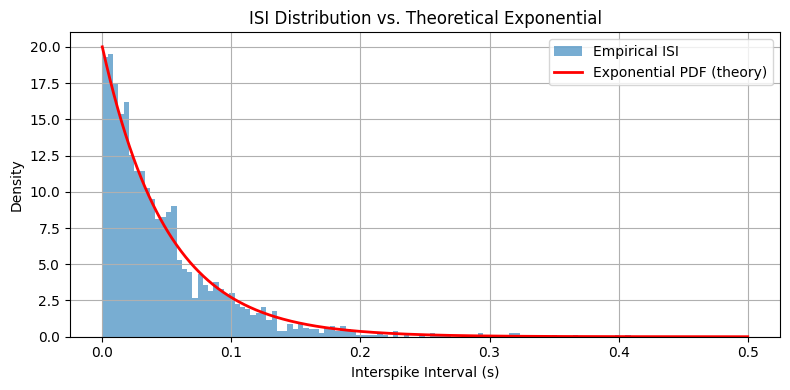

In [9]:
# Plot histogram of ISIs and overlay theoretical PDF
tau_vals = np.linspace(0, 0.5, 1000)
pdf_vals = FR * np.exp(-FR * tau_vals)

plt.figure(figsize=(8, 4))
plt.hist(isi_list, bins=100, density=True, alpha=0.6, label="Empirical ISI")
plt.plot(tau_vals, pdf_vals, 'r-', lw=2, label="Exponential PDF (theory)")
plt.xlabel("Interspike Interval (s)")
plt.ylabel("Density")
plt.title("ISI Distribution vs. Theoretical Exponential")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# This function not moved to poisson_utils because it is not yet correct
def expected_total_vp_cost(q, r, T, output='total'):
    """
    Expected Victor–Purpura distance between two Poisson spike trains,
    using the nearest-neighbour distribution for the matching cost.

    Parameters:
        q (float): Victor–Purpura cost parameter.
        r (float): Firing rate (Hz) of each train (assumed equal).
        T (float): Duration of spike trains in seconds.
        output (str): 'total' (default), 'per_spike', or 'per_sec'.

    Returns:
        float: Expected VP distance under the specified normalization.
    """
    # Expected pairwise match cost under nearest-neighbour distribution
    b = 4 * r / q
    match_cost = (q / (2 * r)) * (1 - (b + 1) * np.exp(-b)) + 2 * np.exp(-b)


    # Expected number of matched and unmatched spikes (same as before)
    expected_diff = np.sqrt(4 * r * T / np.pi)
    expected_pairs = r * T - expected_diff / 2
    expected_unmatched = expected_diff

    total_vp = expected_pairs * match_cost + expected_unmatched

    if output == 'total':
        return total_vp
    elif output == 'per_spike':
        return total_vp / (r * T)
    elif output == 'per_sec':
        return total_vp / T
    else:
        raise ValueError("output must be one of: 'total', 'per_spike', 'per_sec'")


In [12]:
# === Load precomputed simulation data ===
spkd_data = np.load('spkd_poisson_equalized.npz', allow_pickle=True)
firing_rates = spkd_data['firing_rates']
cost_values = spkd_data['cost_values']
spkd_per_spike = spkd_data['spkd_per_spike']
spkd_per_sec = spkd_data['spkd_per_sec']

In [13]:
# === Set parameters ===
duration = 1.0  # seconds
output_type = 'per_spike'  # or 'per_sec'

In [14]:

# === Compute analytical model values ===
model_matrix = np.zeros_like(spkd_per_spike)
for i, q in enumerate(cost_values):
    for j, fr in enumerate(firing_rates):
        model_matrix[i, j] = expected_total_vp_cost(q = q, r = fr, T = duration, output=output_type)

In [15]:

# === Compute parametric estimator values ===
estimate_matrix = np.zeros_like(spkd_per_spike)
for i, q in enumerate(cost_values):
    for j, fr in enumerate(firing_rates):
        estimate_matrix[i, j] = poisson_spkd_estimate(FR = fr, cost = q, output= output_type, duration = duration)

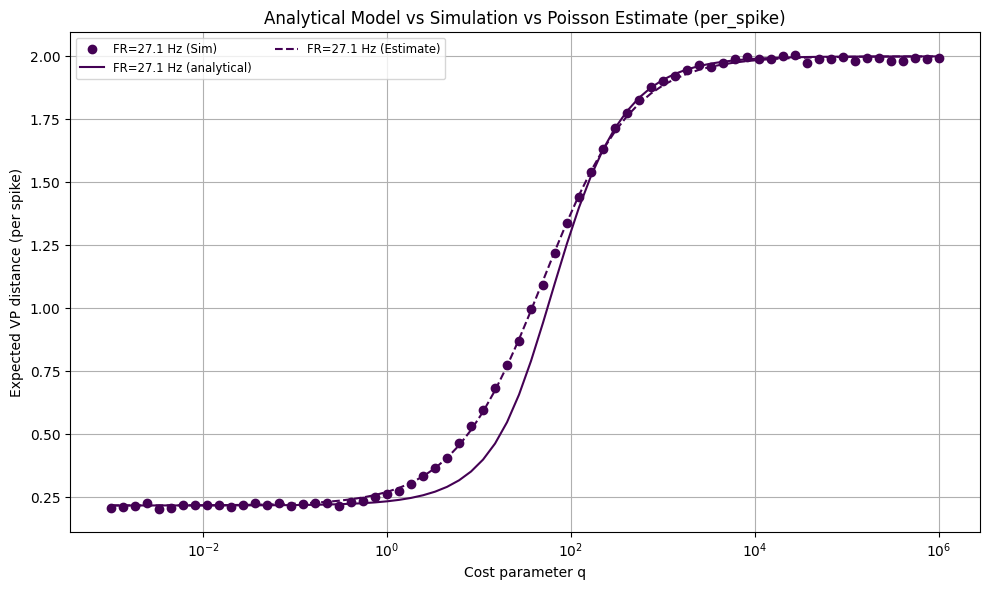

In [16]:

# === Plot all three sources ===
selected_indices = [5]
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_indices)))

plt.figure(figsize=(10, 6))
for idx, j in enumerate(selected_indices):
    sim_vals = spkd_per_spike[:, j] if output_type == 'per_spike' else spkd_per_sec[:, j]
    model_vals = model_matrix[:, j]
    est_vals = estimate_matrix[:, j]

    # Simulation (dots)
    plt.plot(cost_values, sim_vals, 'o', color=colors[idx], label=f'FR={firing_rates[j]:.1f} Hz (Sim)')

    # Analytical model (solid line)
    plt.plot(cost_values, model_vals, '-', color=colors[idx], label=f'FR={firing_rates[j]:.1f} Hz (analytical)')

    # Poisson estimate (dotted line)
    plt.plot(cost_values, est_vals, '--', color=colors[idx], label=f'FR={firing_rates[j]:.1f} Hz (Estimate)')

plt.xscale('log')
plt.xlabel("Cost parameter q")
plt.ylabel(f"Expected VP distance ({output_type.replace('_', ' ')})")
plt.title(f"Analytical Model vs Simulation vs Poisson Estimate ({output_type})")
plt.grid(True)
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

## 🔬 Victor–Purpura Distance Models (Per Spike)

### 🔹 Analytical Model (nearest–neighbour)

**Formula (symbolic form):**
$$
\mathbb{E}\bigl[\text{VP}_{\mathrm{per\_spike}}\bigr]
=
\left(1 - \frac{\sqrt{1/\pi}}{\sqrt{rT}}\right)\!
\left[\frac{q}{2r}\,\bigl(1 - e^{-4r/q}\bigr)\right]
\;+\;
\frac{\sqrt{4/\pi}}{\sqrt{rT}}.
$$

**Formula (numerically simplified):**
$$
\mathbb{E}\bigl[\text{VP}_{\mathrm{per\_spike}}\bigr]
=
\left(1 - \frac{0.5642}{\sqrt{rT}}\right)\!
\left[\frac{q}{2r}\,\bigl(1 - e^{-4r/q}\bigr)\right]
\;+\;
\frac{1.1284}{\sqrt{rT}}.
$$

---

### 🔹 Sigmoid Fit (Empirical)

**Formula (per spike):**
$$
\text{SPKD}(q; \lambda) =
\sqrt{\frac{4}{\pi \lambda}} +
\frac{2 - \sqrt{\frac{4}{\pi \lambda}}}
{1 + \exp\left[
- \left( \frac{-6.074}{\lambda + 7.295} + 1.870 \right)
\left( \log_{10} q - \left(0.396 \cdot \log(\lambda + 1.506) + 0.367 \right) \right)
\right]}
$$

